In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from yellowbrick.cluster import KElbowVisualizer
%matplotlib inline
from mpl_toolkits import mplot3d

## Config

In [2]:
DailyTotalRaw = pd.read_csv('Data\Provincial_Daily_Totals_LABELS.csv')

# DailyTotalsNew = pd.read_csv('C:/Users/graha/Documents/1. Studies/ENGG/Final/Provincial_Daily_Totals_LABELS.csv')

# print(DailyTotalRaw.head())
# print(DailyTotalRaw.shape)

## Wrangle

In [3]:
DailyTotal = DailyTotalRaw.drop(['OBJECTID', 'Province', 'Abbreviation', 'SummaryDate', 'TotalHospitalized', 'DailyHospitalized', 'TotalICU', 'DailyICU'], axis=1)

#### Proportional Data
# on['pCases'] = on['DailyTotals']/on['TotalCases']
# on['pRecovered'] = on['DailyRecovered']/on['TotalRecovered']
# on['pDeaths'] = on['DailyDeaths']/on['TotalDeaths']
# on['pTested'] = on['DailyTested']/on['TotalTested']
# on['pActive'] = on['DailyActive']/on['TotalActive']

#DailyTotal.head()

In [4]:
### Removing label 0 rows (before interventions)
DailyActiveDeath = DailyTotal.drop(DailyTotal[(DailyTotal['Labels'] == 0)].index)
DailyActiveDeath = DailyActiveDeath.reset_index(drop=True)

### Keep only Daily Deaths and Daily New Cases
DailyActiveDeath = DailyActiveDeath.drop(['DailyActive', 'TotalCases', 'TotalRecovered', 'DailyRecovered', 'TotalDeaths', 'TotalTested', 'DailyTested', 'TotalActive'], axis=1)

#DailyActiveDeath


## Function

In [5]:
def standardize(feats):
    '''This function standardizes a feature pair'''
    scaler = StandardScaler()
    scaler.fit(feats)
    feats = scaler.transform(feats)
    return feats

def get_elbow(feats):
    '''This function plots an elbow graph to demonstrate
       the optimal number of kmeans clusters for a given
       feature pair'''
    feats = standardize(feats)
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12))
    visualizer.fit(feats)
    visualizer.show()

def kmeans(n, feats):
    '''This function runs k-means for n clusters
       on a given feature pair'''
    feats = standardize(feats)

    km = KMeans(n_clusters=n).fit(feats)
    centroids = km.cluster_centers_
    
    km.labels_ = [x + 1 for x in km.labels_]

    ax = sns.scatterplot(feats[:, 0], feats[:, 1], hue=km.labels_, palette='Set2', s=50, legend=False)

    sns.scatterplot(centroids[:, 0], centroids[:, 1], color='black', s=100, alpha=0.6)
    # x axis is the first column in dataframe, y is second
    ax.set(xlabel='Daily New Cases', ylabel='Daily Deaths')
    plt.show()

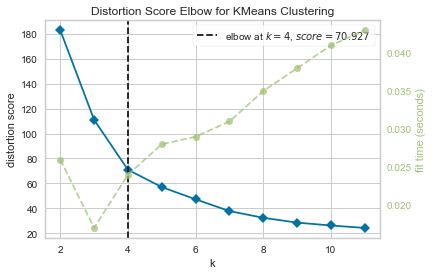

In [6]:
get_elbow(DailyActiveDeath)

C:\Users\graha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\graha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


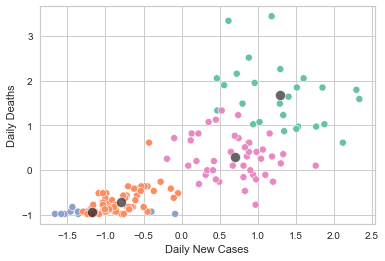

In [7]:
kmeans(4, DailyActiveDeath)

In [8]:
## Standardizing for K-Nearest Neighbor (K Means does it automatically)

DailyActiveDeathKNN = DailyActiveDeath.drop(['Labels'], axis=1)
scaler = StandardScaler()
scaler.fit(DailyActiveDeathKNN)
DailyActiveDeathKNN = scaler.transform(DailyActiveDeathKNN)
DailyActiveDeathKNN = pd.DataFrame(DailyActiveDeathKNN)
DailyActiveDeathKNN = DailyActiveDeathKNN.rename(index=str, columns={0:'DailyTotals', 1:'DailyDeaths'})
DailyActiveDeathKNN['Labels'] = DailyActiveDeath['Labels'].values

#DailyActiveDeathKNN

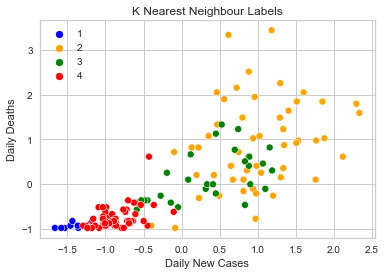

In [9]:
axknn = sns.scatterplot(data=DailyActiveDeathKNN, x='DailyTotals', y='DailyDeaths', hue='Labels', palette = {1:'blue',2:'orange',3:'green',4:'red'})
axknn.set(xlabel='Daily New Cases',ylabel='Daily Deaths')
plt.title('K Nearest Neighbour Labels')
axknn.legend(loc='upper left')
plt.show()
#fig, ax = plt.subplots(figsize=(5,5))


In [10]:
### time series datasets

DailyActiveDeathTS = DailyTotalRaw.drop(['OBJECTID', 'Province', 'Abbreviation', 'TotalHospitalized', 'DailyHospitalized', 'TotalICU', 'DailyICU', 'DailyActive', 'TotalCases', 'TotalRecovered', 'DailyRecovered', 'TotalDeaths', 'TotalTested', 'DailyTested', 'TotalActive'], axis=1)

DailyActiveDeathTS = DailyActiveDeathTS.drop(DailyActiveDeathTS[(DailyActiveDeathTS['Labels'] == 0)].index)
DailyActiveDeathTS = DailyActiveDeathTS.reset_index(drop=True)

DailyActiveDeathStandard = DailyActiveDeathTS.drop(['Labels', 'SummaryDate'], axis=1)
scaler = StandardScaler()
scaler.fit(DailyActiveDeathStandard)
DailyActiveDeathStandard = scaler.transform(DailyActiveDeathStandard)
DailyActiveDeathStandard = pd.DataFrame(DailyActiveDeathStandard)
DailyActiveDeathStandard = DailyActiveDeathStandard.rename(index=str, columns={0:'DailyTotals', 1:'DailyDeaths'})
DailyActiveDeathStandard['Labels'] = DailyActiveDeath['Labels'].values
DailyActiveDeathStandard['SummaryDate'] = DailyActiveDeathTS['SummaryDate'].values

DailyActiveTS = DailyActiveDeathStandard.drop(['DailyDeaths'], axis=1)
DailyDeathTS = DailyActiveDeathStandard.drop(['DailyTotals'], axis=1)

#DailyDeathTS
#DailyActiveTS

In [11]:
#Pulling the labels out of KMeans
feats = standardize(DailyActiveDeath)
km = KMeans(n_clusters=4).fit(feats)
centroids = km.cluster_centers_    
KMLabels = [x + 1 for x in km.labels_]

#Assigning these labels to the time-series dataset 
DailyActiveTS = DailyActiveTS.assign(KMeansLabels = KMLabels)
DailyDeathTS = DailyDeathTS.assign(KMeansLabels = KMLabels)
#print(DailyDeathTS.to_string())

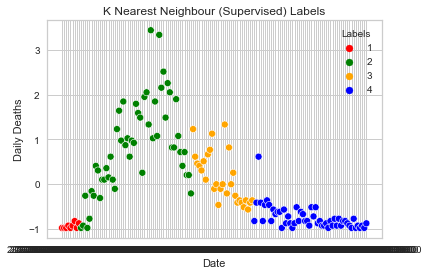

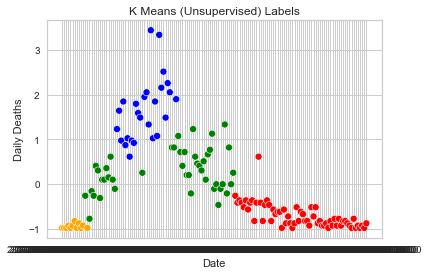

In [12]:
### Standardized deaths over time

axknnDeath = sns.scatterplot(data=DailyDeathTS, x='SummaryDate', y='DailyDeaths', hue='Labels', palette = {1:'red',2:'green',3:'orange',4:'blue'})
axknnDeath.set(xlabel='Date', ylabel='Daily Deaths')
plt.title('K Nearest Neighbour (Supervised) Labels')
plt.show()

axkmeansDeath = sns.scatterplot(data=DailyDeathTS, x='SummaryDate', y='DailyDeaths', hue='KMeansLabels', palette = {1:'red',2:'green',3:'orange',4:'blue'})
axkmeansDeath.set(xlabel='Date', ylabel='Daily Deaths')
plt.title('K Means (Unsupervised) Labels')
axkmeansDeath.get_legend().remove()
plt.show()

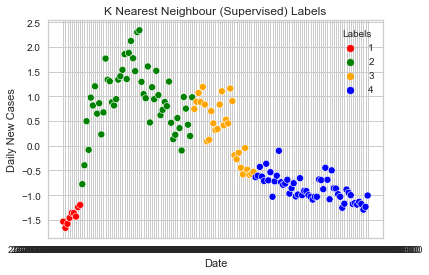

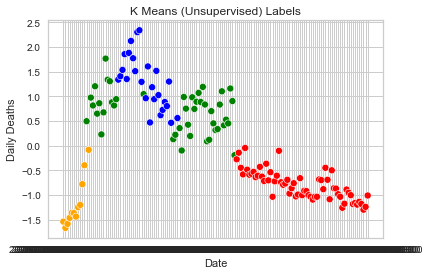

In [15]:
### Standardized New Cases over time

axknnActive = sns.scatterplot(data=DailyActiveTS, x='SummaryDate', y='DailyTotals', hue='Labels', palette = {1:'red',2:'green',3:'orange',4:'blue'})
axknnActive.set(xlabel='Date',ylabel='Daily New Cases')
plt.title('K Nearest Neighbour (Supervised) Labels')
plt.show()

axkmeansDeath = sns.scatterplot(data=DailyActiveTS, x='SummaryDate', y='DailyTotals', hue='KMeansLabels', palette = {1:'red',2:'green',3:'orange',4:'blue'})
axkmeansDeath.set(xlabel='Date', ylabel='Daily Deaths')
plt.title('K Means (Unsupervised) Labels')
axkmeansDeath.get_legend().remove()
plt.show()

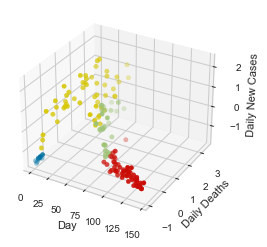

In [14]:
### 3d plot data

ThreeDPlotData = DailyActiveDeathStandard
ThreeDPlotData = ThreeDPlotData.drop(['SummaryDate'], axis=1)
ThreeDPlotData = ThreeDPlotData.assign(SummaryDate=pd.Series(range(1,ThreeDPlotData.shape[0]+1)).values)

ThreeDPlotData1 = ThreeDPlotData.drop(ThreeDPlotData[(ThreeDPlotData['Labels'] != 1)].index)
ThreeDPlotData1 = ThreeDPlotData1.reset_index(drop=True)

ThreeDPlotData2 = ThreeDPlotData.drop(ThreeDPlotData[(ThreeDPlotData['Labels'] != 2)].index)
ThreeDPlotData2 = ThreeDPlotData2.reset_index(drop=True)

ThreeDPlotData3 = ThreeDPlotData.drop(ThreeDPlotData[(ThreeDPlotData['Labels'] != 3)].index)
ThreeDPlotData3 = ThreeDPlotData3.reset_index(drop=True)

ThreeDPlotData4 = ThreeDPlotData.drop(ThreeDPlotData[(ThreeDPlotData['Labels'] != 4)].index)
ThreeDPlotData4 = ThreeDPlotData4.reset_index(drop=True)


### 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x1 = ThreeDPlotData1['SummaryDate']
y1 = ThreeDPlotData1['DailyDeaths']
z1 = ThreeDPlotData1['DailyTotals']

x2 = ThreeDPlotData2['SummaryDate']
y2 = ThreeDPlotData2['DailyDeaths']
z2 = ThreeDPlotData2['DailyTotals']

x3 = ThreeDPlotData3['SummaryDate']
y3 = ThreeDPlotData3['DailyDeaths']
z3 = ThreeDPlotData3['DailyTotals']

x4 = ThreeDPlotData4['SummaryDate']
y4 = ThreeDPlotData4['DailyDeaths']
z4 = ThreeDPlotData4['DailyTotals']

ax.scatter(x1, y1, z1, c='b', marker='o')
ax.scatter(x2, y2, z2, c='y', marker='o')
ax.scatter(x3, y3, z3, c='g', marker='o')
ax.scatter(x4, y4, z4, c='r', marker='o')

ax.set_xlabel('Day')
ax.set_ylabel('Daily Deaths')
ax.set_zlabel('Daily New Cases')

plt.show()
